# Module 2: Simple fit to the PDFgui residual

In this tutorial, we will do a simple mPDF fit for the antiferromagnet MnO using the residual from the atomic PDF fit conducted in PDFgui. The experiment was done on the NOMAD beamline at the Spallation Neutron Source. To keep things simple, we will just refine the mPDF scale factors here.

### Step 1: Do the atomic PDF fit in PDFgui.

A fit has already been done for you, but if you would like to do it yourself, load in the data file called NOM_9999_MnO_5K_ftfrgr.gr. You can use the CIF file called MnO_cubic.cif as a starting model. Do the fit up to 20 A. Note that the magnetic order in MnO causes a distortion of the crystal lattice in which the cubic cell compresses along the [111] direction. For that reason, you will want to create a single variable for alpha, beta, and gamma parameters that is allowed to vary from 90 degrees. I would suggest giving it a slight nudge away from 90 (maybe to 90.1 or so). Also note that the instrumental parameters Qdamp and Qbroad should both be 0.025.

### Step 2: Export the PDFgui fit.

Again, this has already been done for you, but if you want to do it yourself, then select the data file in the Fit Tree, then go to the top of the window and select Data --> Export Fit PDF. Save the file in a convenient place easily accessible from this notebook.

### Step 3: Load in the atomic PDF fit residual and do the mPDF fit.

In [2]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from diffpy.structure import loadStructure

### Set all plots to be inline
%matplotlib widget 
# or try %matplotlib notebook

#### Make the magnetic structure

In [3]:
# read in the mcif
mcif = 'files/1.31_MnO.mcif'
mstr = create_from_mcif(mcif, ffparamkey='Mn2')


# adjust the unit cell parameters to agree with the results of the structural fit
a_fit = 4.4328 # fill in the value from the fit
alpha_fit = 90.6434 # fill in the value from the fit
mstr.struc.lattice.a = 2*a_fit # multiply by two because the magnetic unit cell is 2x2x2 supercell of atomic cell
mstr.struc.lattice.b = 2*a_fit
mstr.struc.lattice.c = 2*a_fit
mstr.struc.lattice.alpha = alpha_fit
mstr.struc.lattice.beta = alpha_fit
mstr.struc.lattice.gamma = alpha_fit

mstr.makeAll()

MagStructure creation from mcif file successful.


#### Extract the data, load it into a Profile object

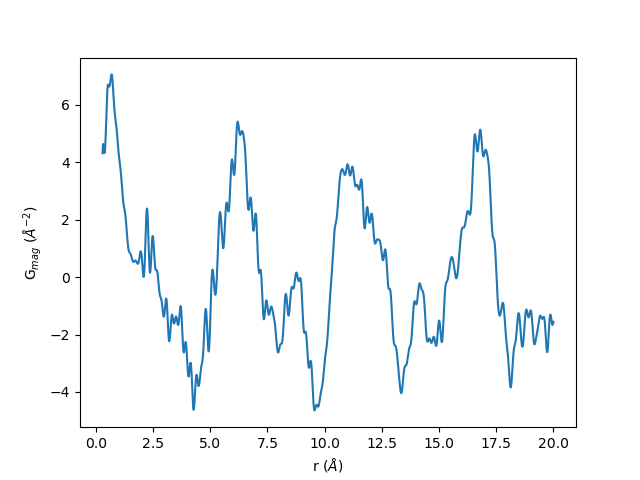

In [4]:
### The getDiffData function reads in a PDFgui fit file and extracts the fit residual
fit_file = 'files/MnOfit_PDFgui_NOMAD.fgr'
r, gobs, gcalc, gdiff = read_fgr(fit_file) # this extracts the results of the atomic PDF fit done in PDFgui
gmag = 1.0*gdiff # we set the experimental mPDF to the fit residual from the atomic PDF fit

### Let's plot it just to make sure it looks right

ax=plt.figure().add_subplot(111)
ax.plot(r, gmag, )
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"G$_{mag}$ ($\AA^{-2}$)")

plt.show()

#### Now we start building the fit in the diffpy.srfit framework

In [5]:
### Create a profile object and load the data into it
from diffpy.srfit.fitbase import Profile

profile = Profile()
profile.setObservedProfile(r, gmag)

#### Make the MPDFcalculator, set up the fit

In [6]:
### Create the MPDFcalculator
mc = MPDFcalculator(mstr)

### Set appropriate rmin and rmax
mc.rmin = profile.xobs.min()
mc.rmax = profile.xobs.max()

In [7]:
### Make the FitContribution
from diffpy.srfit.fitbase import FitContribution
mfit = FitContribution('mfit')
mfit.setProfile(profile)

### Define the function that will calculate the mPDF.
def mpdf(parascale, ordscale):
    ### parascale sets the magnitude of the self-scattering peak below ~1 A
    ### ordscale sets the magnitude of the mPDF
    mc.paraScale, mc.ordScale = parascale, ordscale
    rcalc, gcalc, dcalc = mc.calc(both=True)
    # we want to return the "unnormalized" mPDF dcalc
    return dcalc

### Now we load this function into our FitContribution
mfit.registerFunction(mpdf)

### Now we set the equation that the FitContribution will evaluate during the fit
mfit.setEquation("mpdf(parascale, ordscale)")

In [9]:
### Make the FitRecipe
from diffpy.srfit.fitbase import FitRecipe
recipe = FitRecipe()

### Give the PDFContribution to the FitRecipe
recipe.addContribution(mfit)

### Add the mPDF variables
recipe.addVar(mfit.parascale, 1.0) # 1.0 is the starting value
recipe.addVar(mfit.ordscale, 1.0)

#### Run the refinement

Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale']
  initial values: [1. 1.]
  final values: [23.27141622  1.66848919]


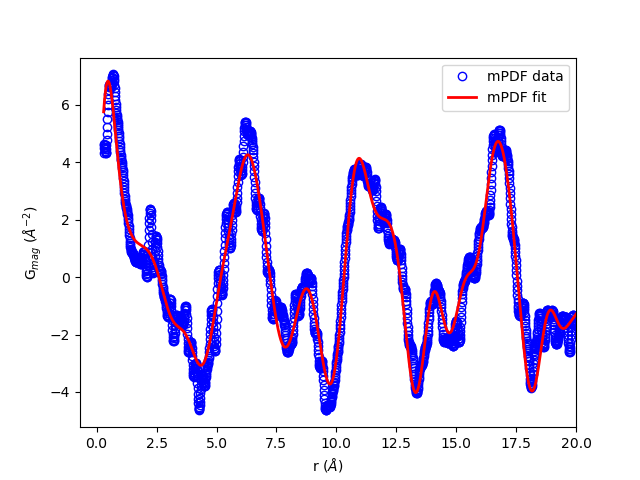

In [10]:
# Turn off printout of iteration number.
recipe.clearFitHooks()

print("Refine using scipy's least-squares optimizer:")
print("  variables:", recipe.names)
print("  initial values:", recipe.values)

from scipy.optimize import least_squares

# This is where we run the least squares minimization
least_squares(recipe.residual, recipe.values)
print("  final values:", recipe.values)

### Plot the results
fit = mfit.evaluateEquation("mpdf")
mdiff = gmag - fit

ax=plt.figure().add_subplot(111)
ax.plot(r, gmag, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, fit, 'r-', lw=2, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"G$_{mag}$ ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1)

plt.show()

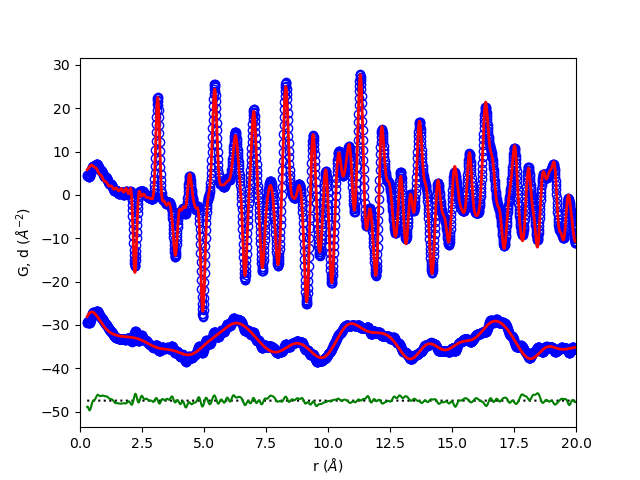

In [12]:
### Plot the total PDF (atomic + magnetic) with the total fit

offset1 = 1.2*gobs.min()
offset2 = offset1 - 8*mdiff.max()

# Make the figure.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r,gobs,marker='o',mfc='none',mec='b',linestyle='none') ### total observed PDF pattern 
ax.plot(r,gcalc + fit,'r-',lw=2) ### calculated atomic PDF
ax.plot(r,gmag+offset1,marker='o',mfc='none',mec='b',linestyle='none') ### residual from atomic PDF fit
ax.plot(r,fit+offset1,'r-',lw=2) ### calculated mPDF
ax.plot(r,np.zeros_like(r)+offset2,'k:')
ax.plot(r,mdiff+offset2,'g-') ### overall fit residual after including atomic and magnetic PDFs
ax.set_xlim(xmin=0,xmax=mc.rmax)
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'G, d ($\AA^{-2}$)')

plt.show()

In [19]:
plt.close('all')

#### Compare the magnetic and nuclear scale factors to determine the moment size

If we call $A$ the nuclear scale factor, $B$ the mPDF ordered scale factor, $n_s$ the fraction of atoms in the system that are magnetic, and $\langle b \rangle$ the average nuclear scattering length of the atoms in the material, then the magnitude of the refined spin vector $\mathrm{S_{fit}}$ is related to the nominal magnitude of the spin vectors $\mathrm{S_{nom}}$ used in the magnetic structure through the equation $\mathrm{S_{fit}} = \sqrt{\frac{\mathrm{B}\langle b \rangle ^2}{\mathrm{A} n_s}} \mathrm{S_{nom}}$. When multiplied by the g factor (e.g. 2 for pure spins without any orbital contributions to the moment), this gives the ordered moment in Bohr magnetons. We have a built-in function to calculate it for a given mPDF calculator and nuclear scale factor.

In [13]:
nucScale = 0.05277 ### refined nuclear scale factor taken from PDFgui

m = calculate_ordered_moment(mc, nucScale) # Note that this assumes a Lande g factor of 2

print('Ordered moment is ' + str(np.round(m, decimals=2)) + ' mu_B')

Ordered moment is 4.62 mu_B


This is fairly consistent with our expectation of S = 5/2 for Mn2+.